# Analyzing Time-Domain Signal Variance using Numpy

**Author**: Stuart Truax `<https://github.com/StuartTruax>`


This tutorial is an introduction to the use of the python numerical computing package `numpy` for computation of time-domain variance of signals, namely the Allan variance $\sigma^{2}(\tau)$. Allan variance is an important measure of statistical variance as a function of time, and is widely used to identify random signal-generating processes from sensors, clocks and other temporal data. 

The tutorial will review some essential methods of using fast fourier transforms (FFTs) and generating power-law noises in `numpy`, followed by an explanation and example of the Allan variance metric. 

For a library of read-to-use Allan variance estimators using `numpy`, please see _[AllanTools](https://pypi.org/project/AllanTools/)_.



## Table of Contents

 ### 1.  [FFTs Using numpy](#section1) 
 ### 2.  [Generating Power-Law Noise with Numpy](#section2)
 ### 3.  [Allan Variance Estimation with Numpy](#section3)

<a id='section1'></a>
# 1. FFTs using Numpy



    
In this tutorial section, a simple sinusoidal signal is generated using numpy, and a fast Fourier transform (FFT)
of the same signal is generated and plotted. The original signal is then recovered using an inverse FFT.

## Library Import

`numpy` and `matplotlib.pyplot` will be used for numerical computation and plotting, respectively. The `numpy.sin` ($sin$) function and `numpy.pi` ($\pi$) constant will be imported as the aliases `sin` and `pi` for clarity of syntax.

In [1]:
import numpy as np
from numpy import sin, pi
import matplotlib.pyplot as plt

## Creating the Sinusoid

In the code below, a time-domain sinusoid of frequency 0.5 Hz and amplitude of 10 is created. The time vector consists of 100 samples sampled at a rate of 10 samples per second.

$$f_s = 10   \frac{_{samples}}{s}$$

$$N_{samples} = 100$$

$$\omega = 2\pi f$$

$$x(t) = A sin(\omega t)$$


By the Shannon-Nyquist theorem, one should be able to perfectly recreate 10s of a 0.5 Hz sinusoid at the specified sampling rate and number of samples to produce 5 periods of the sinusoid. 

$$ N_{periods} = \frac{N_{samples}}{f_s}*f $$

In [2]:
#Sinusoid angular frequency
f = 0.5

#radial frequency omega
omega = 2*pi*f

#sinusoid amplitude
A=10

#Sampling frequency
Fs = 10

#number of samples in time domain
N =100

#generate a time vector
#cast the numpy array to float to avoid integer division by Fs
t = np.arange(0,N)*1/float(Fs)

#generate the sinusoid
X_t = A*sin(omega*t)

## Taking the FFT
The FFT of the signal $x(t)$ is then taken using the `numpy.fft.fft` function. The frequencies `freq` are obtained by dividing the sampling frequency `Fs` by the number of samples `N` and scaling a vector of increments up to `N`. 

Alternatively, the frequency vector `freq` can be acquired from the `numpy.fft.fftfreq` function below. The returned value is scaled by the sampling frequency `Fs` to get the true frequency (See note at end of section). 

Only the first half of the frequency vector will be used to plot the amplitude spectrum, as the FFT is two-sided (i.e. it has both positive and negative frequency components, symmetric about zero frequency). 

Additionally, to account for the conjugate symmetry of the FFT and the vector poduct used to generate the FFT, an amplitude of normalization factor of $C = 2/N$ is calculated. Whenever the amplitude spectrum of $X$ is plotted, the absolute value of $X(f)$  multiplied by the normalization factor will be used to obtain the correct amplitude spectrum. (Continue to the section "Plotting the Amplitude FFT in Terms of True Frequency and Amplitude" to see how both `freq` and `C` are used in plotting)

In [3]:
#FFT of the time domain signal
X_omega = np.fft.fft(X_t)

#Frequency vector calculation
freq = (float(Fs)/N)*np.arange(0,N)

#Alternative way of calculating the frequency vector
freq = np.fft.fftfreq(t.shape[-1])*Fs

#FFT amplitude normalization factor
C=2/float(N)

## Taking the inverse FFT
The inverse of the FFT is then taken to recover the original time-domain sinusoid. The function `numpy.fft.ifft` will generate an array of complex numbers. The imaginary parts of these complex numbers will generally be 0, but Python will nonetheless give a warning about casting these values to real numbers. The imaginary component is thus trimmed using the `numpy.real` function to preclude this warning. 

In [4]:
#Inverse FFT of the frequency-domain signal
X_t_inverse = np.real(np.fft.ifft(X_omega))

## Comparing the Original and Recovered Time-Domain Signal
The orginal and recovered time-domain signals are plotted, and perfectly overlay each other, as seen below. 

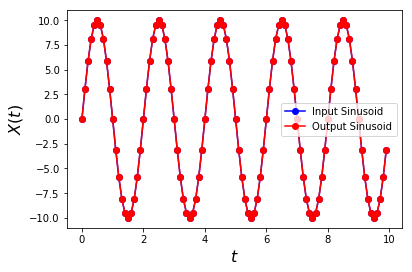

In [5]:
plt.figure(1)
plt.plot(t,X_t,color = 'blue', marker = "o")
plt.plot(t,X_t_inverse,color = 'red', marker = "o")
plt.ylabel(r"$X(t)$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.legend(["Input Sinusoid", "Output Sinusoid"])
plt.show()

## Plotting the Amplitude FFT in Terms of True Frequency and Amplitude

Only the first half of the frequency and FFT vectors are plotted to account for the symmetry of the FFT. 

`freq[0:N/2]`

Notice the high-amplitude frequency component at 10 Hz. This single component is the sinusoid whose parameters were specified at the beginning of the tutorial. Using the amplitude normalization factor calculated above, the correct ampltude of 10 is shown in the plot using the below snippet of code:

`C*np.absolute(X_omega[0:N/2])`

where `C=2/float(N)`, `N` the number of samples. 

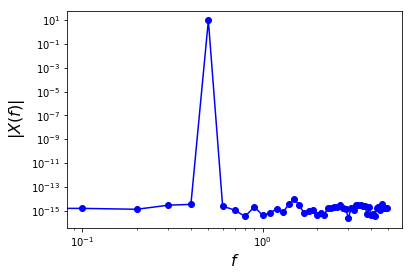

In [6]:
plt.figure(2)
plt.loglog(freq[0:N/2],C*np.absolute(X_omega[0:N/2]),color = 'blue', marker = "o")
plt.ylabel(r"$|X(f)|$", fontsize=16)
plt.xlabel(r"$f$", fontsize=16)
plt.show()

**NOTE**:
    
**Accounting for the sampling frequency**: The FFT algorithm takes a set of time-domain samples $x$ as input and produces a vector of frequency-domain amplitudes and phases encoded as complex numbers $X(f)$. The algorithm does not consider the sampling rate of the input signal, thus the indices of the vector have no inherent frequency reference. The frequncy components are only computed in terms of the total number of samples of the time-domain signal and the sampling frequency (see https://en.wikipedia.org/wiki/Fast_Fourier_transform). The FFT algorithm guarantees that that the original time-domain signal $x(t)$ will be recovered upon applying the inverse FFT to $X(f)$. Only by maintaining information about the sampling frequency of $x(t)$ can the FFT $X(f)$ be plotted in terms of its "true" frequency components.

## References
[1] http://matteolandi.blogspot.com/2010/08/notes-about-fft-normalization.html

[2] https://en.wikipedia.org/wiki/Fast_Fourier_transform

<a id='section2'></a>
# 2. Generating Power-Law Noise with Numpy


    
In this tutorial section, a power-law noise signal is generated using numpy. The procedure described can be used to generate any power-law noise process. Such processes are often of interest in the domains of economics and physics [1-4], and will be used in the subsequent tutorial on Allan variance.


## Library Import

`numpy` and `matplotlib.pyplot` will be used for numerical computation and plotting, respectively. Additionally, at the end of the section, the file `NoiseGenerator.py` will be imported to generate the colored noises in a compact fashion.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

## Generating Gaussian Noise

The procedure for generating power-law (i.e. colored) noise begins with sampling from a Gaussian distribution to generate a discrete-time stochastic process composed of Gaussian deviates. The generated process will have the spectral characteristic of white noise, which has a flat power spectral density (PSD) [5-7].

Gaussian noise appears in many phenomena throughout the sciences, and, due to the central limit theorem, will tend to be the distribution generated by any process that is an additive function of many random variables. An important example of Gaussian noise phenomena is thermomechanical noise in physics [6]. 


Gaussian noise is represented in the time domain by a time series where each time point is a sample from a Gaussian (in this case, a standard Normal) distribution. That is:

$w(t) = \epsilon_{t}$, where $\epsilon_{t} \sim N(0,1) $

Below, an initial Gaussian time series will be generated for later transformation in the frequency domain. 



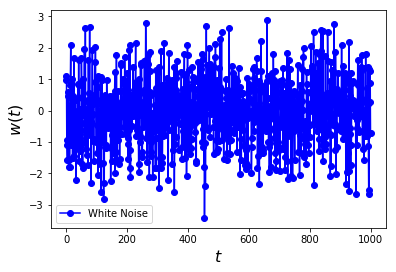

In [8]:
#Sampling frequency
Fs = 1
#number of samples in time domain
N =1000

#generate a time vector
t = np.arange(0,N)*1/float(Fs)


#generate the gaussian samples (i.e. white noise)
w_t = np.random.normal(0, 1, (N,1))


#FFT of the time domain white noise signal
W_omega = np.fft.fft(w_t)

#frequency vector
freq = np.fft.fftfreq(t.shape[-1])

#fft amplitude normalization factor
C = 2/float(N)


#Plot of Gaussian time series
plt.figure(1)
plt.plot(t,w_t,color = 'blue', marker = "o")
plt.ylabel(r"$w(t)$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.legend(["White Noise"])
plt.show()

## Transforming the Gaussian Noise into Colored Noise

After the white noise is generated, colored noise will be generated by multiplying the white noise FFT (i.e. its amplitude spectral density, ASD) by a power-law function of frequency in the frequency domain. 

It is often of interest, to generate colored noises which have a PSD that follows a power law curve [1-4]:

$$S(f) \sim hf^{-\alpha}$$

In the frequency domain, the Gaussian noise can be transformed into colored noise by multiplying each frequency bin of the ASD by the factor:

$$\sqrt{f^{-\alpha}_{i}}$$

where $\alpha$ is parameter specifying the color of the noise. Given that the PSD is proportional to the squared-amplitude, the square-root is necessary in scaling the ASD to produce the appropriate power-law dependency in the PSD.

One may notice that the power-law noise distributions defined so far have a singularity at zero frequency. Depending on the definition of colored noise used, this complication is often taken care of by an additive constant in the denominator of the distribution, e.g.:

$$\frac{h}{\sqrt{1+af^{-\alpha}_{i}}}$$

This tutorial will work around this complication by leaving whatever zero frequency component that exists in any modified spectrum untouched. That is, all frequency components except the zero frequency component will reflect a power-law spectal density. 

A common example of colored noise is pink noise or $1/f$-noise, for which $\alpha=1$. Below, such a colored noise is created using the above relations with a simple for-loop:

In [9]:
#copy the white noise
X_omega_c = np.ndarray(W_omega.shape, dtype=np.complex_)

#shift the noise in frequency space so the DC value is at the center of the vector
W_omega = np.fft.fftshift(W_omega)

#power parameter
alpha = 1

#calculate half the length of spectrum to properly shape the noise
halfSpectrumLength = N/2

# color the noise according to the power parameter alpha
#leave the DC component at X_omega[halfSpectrumLength] untouched
for i in range(halfSpectrumLength+1,N):
            X_omega_c[i] = np.divide(W_omega[i],np.sqrt((i-halfSpectrumLength)**alpha))
for i in range(halfSpectrumLength-1,-1,-1):
            X_omega_c[i] = np.divide(W_omega[i],np.sqrt((halfSpectrumLength-i)**alpha))

The colored noise is now transformed back into the time domain, following an inverse shift of the halves of the spectrum:

In [10]:
#shift the zero-frequency component back to the beginning of the vector
#and perform the inverse FFT
X_t_inverse = np.real(np.fft.ifft(np.fft.ifftshift(X_omega_c)))

The colored noise time series is now plotted against the original Gaussan time series:

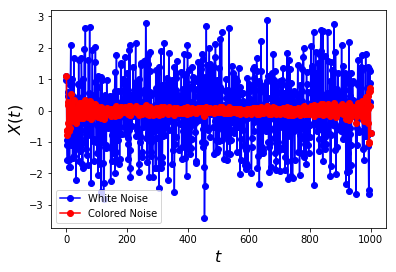

In [11]:
plt.figure(2)
plt.plot(t,w_t,color = 'blue', marker = "o")
plt.plot(t[0:N],X_t_inverse[0:N],color = 'red', marker = "o")
plt.ylabel(r"$X(t)$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.legend(["White Noise", "Colored Noise"])
plt.show()

In the frequency domain, the characteristic of the colored noise vis-a-vis the white noise shows a definite difference, as shown below:

/Users/stuarttruax/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


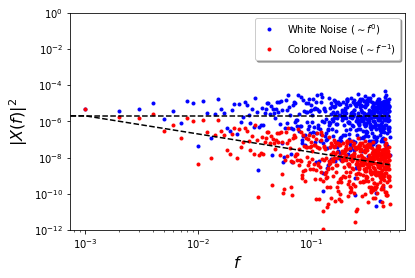

In [12]:
#guide lines
h = 1e-3
pink_line = np.ones(N/2)
white_line = h*np.ones(N/2)
for i in range(0,N/2):
    if(i==0):
        pink_line[i] = h/float(0.000001)
    else:
        pink_line[i] = h/float(i)
        
#shift both the white and pink noise back
X_omega_c = np.fft.ifftshift(X_omega_c)
W_omega = np.fft.ifftshift(W_omega)


plt.figure(3)
plt.loglog(freq[0:N/2]*Fs,(C*np.real(np.absolute(W_omega[0:N/2])))**2,'b.')
plt.loglog(freq[0:N/2]*Fs,(C*np.absolute(X_omega_c[0:N/2]))**2,'r.')
plt.loglog(freq[0:N/2]*Fs,C*pink_line,'k--')
plt.loglog(freq[0:N/2]*Fs,C*white_line,'k--')
plt.ylim((1e-12, 1))
plt.ylabel(r"$|X(f)|^2$", fontsize=16)
plt.xlabel(r"$f$", fontsize=16)
plt.legend(["White Noise ($\sim f^{0}$) ", "Colored Noise ($\sim f^{-1}$)"],  fancybox=True, shadow=True)
plt.show()

The white noise has no frequency dependence (i.e. an $\alpha=0$ in $S(f) \sim hf^{-\alpha}$), whereas the colored noise for $\alpha=1$ has a frequency dependence with -1 slope when plotted in a log-log plot, as above. 

A variety of power-law colored noises can be created, each coresponding to a different slope when their PSDs are plotted log-log in the frequency domain, as shown below.

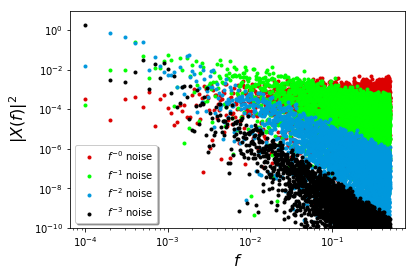

In [13]:
from NoiseGenerator import *

#sample size
N=10000

#alpha vector
alphas = [0,1,2,3]

#generate several vectors time domain noises using the above alpha parameters
Y = np.empty((len(alphas),N),np.dtype('c16'))

#nominal sampling frequency
Fs=1

#Frequency vector calculation
freq = (float(Fs)/N)*np.arange(0,N)



#fft amplitude normalization factor
C = 2/float(N)

for alpha in alphas:
    Y_temp = np.fft.fft(NoiseGenerator.power_law_noise(N,alpha,1.).flatten())
    Y[alpha] = Y_temp



#generate the colormap for the traces
numplots = len(alphas)
colors = plt.cm.nipy_spectral(np.linspace(0.9,0,numplots))

#generate the labels for the traces
labels =[]
for i in alphas:
    labels.append(r"$f^{-"+str(i)+"}$ noise")

#plot the figure
plt.figure(2)
for i in range(0,len(alphas)):
    plt.loglog(freq[0:N/2]*Fs,(C*np.absolute(Y[i][0:N/2]))**2,'.', color = colors[i])
plt.ylim((1e-10, 10))
#plt.xlim((1e-3,1))
plt.ylabel(r"$|X(f)|^2$", fontsize=16)
plt.xlabel(r"$f$", fontsize=16)
plt.legend(labels, fancybox=True, shadow=True)
plt.show()

## Conclusion and Further Reading
This section of the tutorial has shown how create a power-law noises using the built-in Gaussian deviate generator in numpy. 

The method shown here is only one way of creating power-law noises in the frequency domain. Numerous algorithms exist for creating these noise densities in both the time and frequency domains with high computational efficiency. It is suggested that one take a look at the  `noise.py` file in the GitHub repository for _[AllanTools](https://pypi.org/project/AllanTools/)_. It is full of clever tricks for creating various noise densities. 

## References

[1] https://en.wikipedia.org/wiki/Pink_noise 

[2] F. N. Hooge, “1/f noise,” Physica B+C, vol. 83, no. 1, pp. 14–23, 1976.

[3] M. S. Keshner, “1/f noise,” Proceedings of the IEEE, vol. 70, no. 3, pp. 212–218, 1982.

[4] A. Clauset, C. R. Shalizi, and M. E. J. Newman, “Power-Law Distributions in Empirical Data,” Society of Industrial and Appled Mathematicians Review, vol. 51, no. 4, pp. 661–703, 2009.

[5] https://en.wikipedia.org/wiki/White_noise

[6] https://en.wikipedia.org/wiki/Thermal_fluctuations

[7] https://en.wikipedia.org/wiki/Spectral_density

[8] http://kmdouglass.github.io/posts/correlated-noise-and-the-fft.html



<a id='section3'></a>
# 3. Allan Variance Estimation with Numpy

This tuturial section will discuss the use of the Allan variance in characterizing time-domain signal variation using Numpy.

## Library Import

`numpy` and `matplotlib.pyplot` will be used for numerical computation and plotting, respectively. Additionally, the files `AllanVariance.py` and `NoiseGenerator.py` will be imported to generate the Allan variance estimation and colored noises, respectively.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from AllanVariance import  *
from NoiseGenerator import *

## Introduction to Allan Variance

### A. Motivation

Real-world signals often have many components, each varying over a different timescale. An example would be a signal $x[n]$ composed of a time-varying component $x_{1}[n]$ and an additive offset $x_{offset}$:

$$x[n]= x_{1}[n]+x_{offset}$$

In the real-world, it is very rarely the case that $x_{offset}$ is constant with time; it often varies randomly over _some_ timescale. This timescale may be so large that that $x_{offset}$ maybe treated _quasistatically_, i.e. over short timescales it is effectively constant. However, one may wish to know over what timescale $x_{offset}$ varies, and what underlying process contributes to this variaton. 

The Allan variance is a way of characterizing the variation of a signal as a function of _timescale_ [1-5]. Like a standard statistical variance, it is an expectation of an expectation. The key difference with the Allan variance is that the Allan variance measures the variance of a signal per squared unit time, hence becoming a _time variance_ expressed in the time domain. This constrasts it with the Fourier transform, which can be used for equivalent purposes in the frequency domain. Like the Fourier transform, the Allan variance can be applied to samples from probability distributions to identify the sample-generating process. 

The following sections serve as a brief introduction to the Allan variance. The reader is encouraged to also consult the references [1-5].

### B. Allan Variance Definition

Given a discrete-time signal $x[n]$ with timestep $\tau = \frac{1}{f_s}$, $f_{s}$ the sampling frequency, the Allan variance is defined as: 

$$\sigma^{2}(\tau) = \frac{1}{2 \tau^{2}} \langle (x_{n+2}- 2 x_{n+1} + x_n)^{2} \rangle $$

Examining the above definition, one sees that, consistent with its definition as a variance, it is an expectation of a squared quantity. Futhermore, it is normalized by $1/\tau^{2}$, giving it units of the signal squared per unit time squared (i.e. a variance per unit time squared). In a sense, it is a variance of the temporal derivative of the signal. Once again, it is not variance alone it is measuring, but the _time variance_. 

Usually one wishes to evaluate several values of  $\tau_{i}$, $i=1,..,k$, for a given signal $x[n]$. This is accomplished by downsampling $x[n]$ with several sampling rates $f_{s,i} = \frac{1}{\tau_i}$ and applying the above equation for $\tau_i$. 

### C. Estimator 

The Allan variance definition recited above applies to signals $x[n]$ with an infinite number of samples, thus allowing $\sigma^{2}(\tau)$ to be exactly calculated. In practical situations, signals have a finite number of samples $N$. In such a case, there are numerous estimators of the Allan variance that can be applied to the signal. One common one is the _[overalapped variable $\tau$ estimator](https://en.wikipedia.org/wiki/Allan_variance#Overlapped_variable_τ_estimators)_, recited below:

$$\sigma^{2}(M\tau_0, N) \cong \frac{1}{2 (M\tau_0)^{2}(N-2M)} \sum_{k=1}^{N-2M-1} ((x_{k+2M}-x_{k+M})-(x_{k+M}-x_{k}))^{2}$$

where:
  - $N$ is the number of samples in the signal.
  - $\tau_0$ is the minimum timescale, typically $\tau_o = \frac{1}{f_s}$, $f_s$ the sampling frequency.
  - $M$ is the cluster size,$\tau = M \tau_0$. $M$ defines the downsampling of $x[n]$. 
  
As $N \to \infty$, the above estimator converges to the definition of Allan variance in expectation.
  
Given that several values of $\tau$ are desired to calculate an Allan variance curve $(\tau,\sigma^{2}(\tau))$, the above estimator requires the evaluation of two loops: one for the several values of $M$, the other for the summation. This gives a worst-case time complexity of $O(N^2)$ for the above estimator. Libraries such as _[AllanTools](https://pypi.org/project/AllanTools/)_ use array arithmetic to achieve sub-polynomial time complexity [6-7].

### D. Comparison between the Fourier Transform and Allan Variance

Given the power spectral density (PSD) $S(f)$ of a signal, its Allan variance variance can be computed using the following transformation:

$$\sigma^{2}(\tau) \cong 2 \int_{0}^{f_h} S(f) \frac{sin^{4}(\pi\tau f)}{(\pi\tau f)^{2}} df$$

where $f_h$ is the bandwidth, which in turn defines the minimum $\tau$ value in the above expression.

Given this equivalence between the PSD and the Allan variance, it can be expected that power-law noise processes can be readily identified by their Allan vairance characteristic. The table below gives expressions for the PSD and Allan variance of several common noise processes:

#### Table 1. Allan Variance and PSDs of Several Colored Noises

|Common Name| Power Spectral Density S(f) | Allan Variance $\sigma^{2}(\tau)$  |
|------|------|------|
|White Noise|   $hf^{0}$  | $\frac{1}{2}h\tau^{-1}$|
|Pink Noise|   $hf^{-1}$   | $2ln(2)h\tau^{0}$|
|Red Noise|   $hf^{-2}$   | $\frac{2\pi^{2}}{3}h\tau^{1}$|

Generally, for a PSD of the form $af^{\alpha}$, the corresponding Allan variance will be $b\tau^{-\alpha-1}$, $a$ and $b$ some constants. 

## Example: Sinusoids and Colored Noises

As an example of Allan variance estimation, consider a composite signal consisting of a pure sinusoid and a Gaussian noise. The component signals are created and superposed, with the component and composite signals plotted below. 

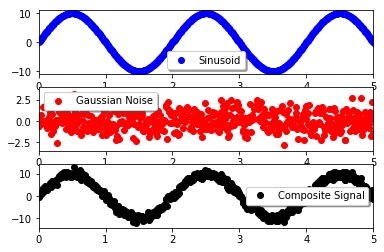

In [15]:
#number of samples in time domain
N = 10000

##Sinusoid
#Sinusoid angular frequency
f = 0.5
#radial frequency omega
omega = 2*np.pi*f
#sinusoid amplitude
A=10
#Sampling frequency
Fs = 100

#generate a time vector
t = np.arange(0,N).astype(float)/Fs
#generate the sinusoid
X1 = A*np.sin(omega*t)

##White Noise
X2 = NoiseGenerator.power_law_noise(N,0,1).flatten()

##Composite signal
X = X1+X2

#Plots
x_ax_lims = [0,5]

plt.figure(1)
plt.subplot(311)
plt.plot(t, X1, 'bo')
plt.xlim(x_ax_lims)
plt.legend(["Sinusoid"],fancybox=True, shadow=True)
plt.subplot(312)
plt.plot(t, X2, 'ro')
plt.xlim(x_ax_lims)
plt.legend(["Gaussian Noise"],fancybox=True, shadow=True)
plt.subplot(313)
plt.plot(t, X, 'ko')
plt.xlim(x_ax_lims)
plt.legend(["Composite Signal"],fancybox=True, shadow=True)
plt.show()


Next, the Allan variances are evaluated for all three signals (pure sinusoid, Gaussian noise and composite).

In [16]:
tausS,sigmaS = AllanVariance.overlapped_variable_tau(X1,Fs,10**-3,10**-1.01,100)
tausN,sigmaN = AllanVariance.overlapped_variable_tau(X2,Fs,10**-3,1,100)
tausC,sigmaC = AllanVariance.overlapped_variable_tau(X,Fs,10**-3,10**-1.01,100)

Below the Allan variance curves for the sinusoid and the Gaussian noise signal are plotted. Notice the $\tau^{-1}$ slope of the Allan variance for the Gaussian noise signal, which is consistent with the table above. Also, notice that pure sinusoids have an Allan variance characteristic that peaks at $\tau = 1/f$, where $f$ is the sinusoid's fundamental frequency of 0.5 Hz. 

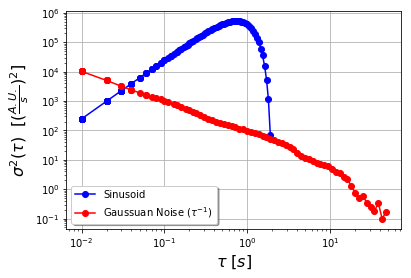

In [18]:
plt.figure(2)
plt.loglog(tausS,sigmaS,color = 'blue', marker = "o")
plt.loglog(tausN,sigmaN,color = 'red', marker = "o")
plt.ylabel(r"$\sigma^2(\tau)$  $[(\frac{A.U.}{s})^{2}]$", fontsize=16)
plt.xlabel(r"$\tau$ $[s]$", fontsize=16)
plt.legend(["Sinusoid",r"Gaussuan Noise ($\tau^{-1}$)"],fancybox=True, shadow=True)
plt.grid(True)
plt.show()

Lastly, the Allan variance for the composite signal is plotted. Upon inspection, one can easily determine that the composite signal has a white noise component ($\tau^{-1}$ slope) and strong peak in the Allan variance at timescales less than 1 second, which is attributable to the sinusoid:

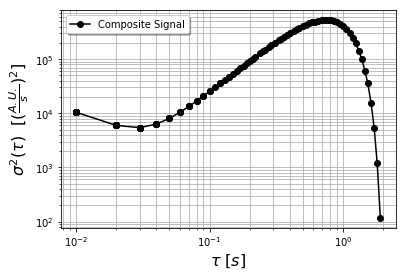

In [19]:
plt.figure(3)
plt.loglog(tausC,sigmaC,color = 'k', marker = "o")
plt.ylabel(r"$\sigma^2(\tau)$  $[(\frac{A.U.}{s})^{2}]$", fontsize=16)
plt.xlabel(r"$\tau$ $[s]$", fontsize=16)
plt.legend(["Composite Signal"],fancybox=True, shadow=True)
plt.grid(True, which="both")
plt.show()

Lastly, to reproduce the Allan variance characteristics recited in Table 1, several colored noises are created, evaluated and plotted in terms of their Allan variances.

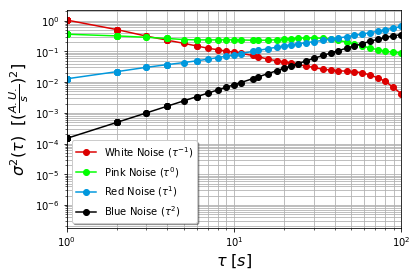

In [20]:
alphas = [0,1,2,3]
N = 1000
Fs=1

numTaus = 100

taus_m = dict()
sigmas_m = dict()

for i in range(0,len(alphas)):
    Y_temp = NoiseGenerator.power_law_noise(N,alphas[i],1).flatten()
    taus,sigmas= AllanVariance.overlapped_variable_tau(Y_temp,Fs,1,100,numTaus)
    taus_m[alphas[i]] = taus.flatten()
    sigmas_m[alphas[i]] = sigmas.flatten()
    

#plotting
#generate the colormap for the traces
numplots = len(alphas)
colors = plt.cm.nipy_spectral(np.linspace(0.9,0,numplots))

plt.figure(4)
for i in range(0,len(alphas)):
    plt.loglog(taus_m[i],sigmas_m[i],color = colors[i], marker = "o")

plt.ylabel(r"$\sigma^2(\tau)$  $[(\frac{A.U.}{s})^{2}]$", fontsize=16)
plt.xlabel(r"$\tau$ $[s]$", fontsize=16)
plt.legend([r"White Noise ($\tau^{-1}$)",r"Pink Noise ($\tau^{0}$)",r"Red Noise ($\tau^{1}$)",r"Blue Noise ($\tau^{2}$)"],fancybox=True, shadow=True)
plt.grid(True, which="both")
plt.xlim([1,100])
plt.show()

The slopes stated in Table 1 are reproduced in the plot, with each colored noise increasing in slope in proportion to the exponent of their inverse frequency dependence. 

## Conclusion and Further Reading

 - Allan variance is a time-domain measure of a signal's variation. Allan variance is evaluated over a given timescale $\tau$, and a set of ordered pairs $(\tau, \sigma^{2}(\tau))$ constitues an Allan variance plot. 

 - Allan variance can be computed from a signal's power spectral density, and the two can be seen as images of each other in the time- and frequency-domains, respectively. 

 - The slope of the Allan variance identifies the signal-generating process acting at a given timescale .

 - Allan variance always has units of squared quantity per squared time.

 -  The implementations contained in this tutorial are primarily for illustration purposes. For an excellent collection of python implementations of Allan variance estimators, the reader is directed to the library _[AllanTools](https://pypi.org/project/AllanTools/)_, which is highly recommended for more intensive uses of the Allan variance metric. 


## References

[1] "Allan variance,"  https://en.wikipedia.org/wiki/Allan_variance

[2] W.J. Riley, NIST Special Publication 1065 , July 2008, https://nvlpubs.nist.gov/nistpubs/Legacy/SP/nistspecialpublication1065.pdf

[3] D. Allan, H. Hellwig, P. Kartaschoff, J. Vanier, J. Vig, G.M.R. 	Winkler, N. Yannoni, "Standard terminology for fundamental 	frequency time metrology," 42nd Annual Frequency Control 	Symposium, 1988 

[4]  “J.R. Vig, IEEE Standard Definitions of Physical Quantities for 	Fundamental Frequency and Time Metrology (IEEE Std 1139-	1999), IEEE, 1999

[5]  D.A. Howe, D.W. Allan, and J.A. Barnes, "Properties of signal 	sources and measurement methods," Proc. of 35th Annual 	Symposium on Frequency Control, 1981  

[6] "Algorithms for calculating variance," https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

[7] AllanTools, https://pypi.org/project/AllanTools/

 
